In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)


In [2]:
import cv2

Задаю маршрут для чтения

In [3]:
PAHT_label = 'images2/train_masks/'
PAHT_image = 'images2/train/'
  

Читаем имена файлов из рабочего каталога

In [4]:
import os, fnmatch
imag = os.listdir(PAHT_image)
imag_label = os.listdir(PAHT_label)

In [10]:
imag,imag_label

(['00087a6bd4dc_01.jpg',
  '00087a6bd4dc_02.jpg',
  '00087a6bd4dc_03.jpg',
  '00087a6bd4dc_04.jpg',
  '00087a6bd4dc_05.jpg',
  '00087a6bd4dc_06.jpg',
  '00087a6bd4dc_07.jpg',
  '00087a6bd4dc_08.jpg',
  '00087a6bd4dc_09.jpg',
  '00087a6bd4dc_10.jpg',
  '00087a6bd4dc_11.jpg',
  '00087a6bd4dc_12.jpg',
  '00087a6bd4dc_13.jpg',
  '00087a6bd4dc_14.jpg',
  '00087a6bd4dc_15.jpg',
  '00087a6bd4dc_16.jpg',
  '02159e548029_01.jpg',
  '02159e548029_02.jpg',
  '02159e548029_03.jpg',
  '02159e548029_04.jpg',
  '02159e548029_05.jpg',
  '02159e548029_06.jpg',
  '02159e548029_07.jpg',
  '02159e548029_08.jpg',
  '02159e548029_09.jpg',
  '02159e548029_10.jpg',
  '02159e548029_11.jpg',
  '02159e548029_12.jpg',
  '02159e548029_13.jpg',
  '02159e548029_14.jpg',
  '02159e548029_15.jpg',
  '02159e548029_16.jpg',
  '03a857ce842d_01.jpg',
  '03a857ce842d_02.jpg',
  '03a857ce842d_03.jpg',
  '03a857ce842d_04.jpg',
  '03a857ce842d_05.jpg',
  '03a857ce842d_06.jpg',
  '03a857ce842d_07.jpg',
  '03a857ce842d_08.jpg',


#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [11]:
images = []
segments = []
image_size = (112,160)
for i_name in imag[:3500]:
    images.append(image.load_img(PAHT_image+i_name ,target_size = image_size))
for i_name in imag_label[:3500]:
    segments.append(image.load_img(PAHT_label+i_name, target_size = image_size))


Посмотрели на входные кадры

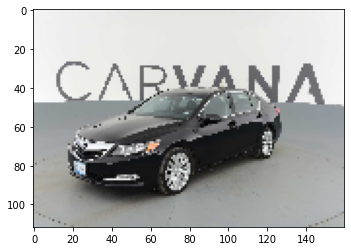

In [12]:
plt.imshow(images[2].convert('RGBA'))
plt.show()

Посмотрим на цели

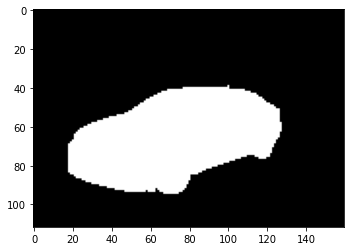

In [13]:
plt.imshow(segments[2].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [14]:
xTrain_Test = []

for img in images:
    x = image.img_to_array(img)
    xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [15]:
print(xTrain_Test.shape)

(3500, 112, 160, 3)


Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Car	  ( 0, 0, 0)	Object

Void	( 255,255, 255)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

  - каждому классу (цвету) ставим в соответствие свою карту ответов y_cat, где 1 , если цвет этого пикселя равен номеру карты и 0 в противном случае
  - для визуализации строим карту цветов y_ind, где пиксель содержит номер цвета

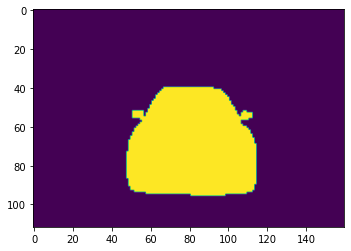

In [16]:
def Color2index(y):
  #y - входное изображение разметки (УхХхС - цветное )
  # карту цветов y_ind
  # карту ответов one-hot-encoding y_cat

  # список актуальных цветов разметки
    arr_col=[[0,0,0],[255,255,255]]
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        #найдем все точки цвета i_color
        ind_i = np.where((y[:,:,0] == i_color[0]) & (y[:,:,1] == i_color[1]) & (y[:,:,2] == i_color[2]))

        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


Проверяем максимальное значение слоя 1 (по нашей схеме должна быть 1)

In [17]:
np.max(cat_yi[:,:,1] )

1.0

Оценим размер карты ответа:
  - число каналов равно числу классов
  - размер карты равер размеру картинки входа

In [18]:
cat_yi.shape

(112, 160, 2)

Сегментированную картинку в  One hot encoding (разметка на 2 класса)**

In [19]:
yTrain_Test = []

for seg in segments:
    y_cat,_,_ = Color2index(image.img_to_array(seg))
    yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [20]:
print(yTrain_Test.shape)

(3500, 112, 160, 2)


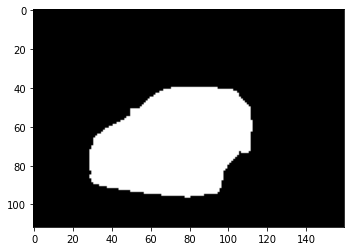

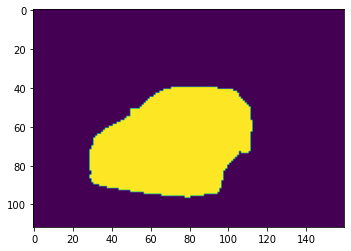

In [21]:
n = 1
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,n]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [22]:
N = 2800
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [23]:
yTest.shape

(700, 112, 160, 2)

In [24]:
print(xTrain.shape)
print(yTrain.shape)

(2800, 112, 160, 3)
(2800, 112, 160, 2)


#Создаём и обучаем U-net

In [25]:
from tensorflow.keras.utils import plot_model

**Unet**

In [26]:
def Unet(num_classes = 2, input_shape= (112, 160, 3)):
  #num_classes = 2, - число классов ответа
  #input_shape= (112, 160, 3) - размер входной картинки

  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 56x80

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 28x40

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #14x20

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out) # 7x10

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # 7x10
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #28x40
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 56x80
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 112x160
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 112, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 160, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

                                                                                                  
 activation_9 (Activation)      (None, 14, 20, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 7, 10, 512)  0           ['activation_9[0][0]']           
                                                                                                  
 block5_conv1 (Conv2D)          (None, 7, 10, 512)   2359808     ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_10 (BatchN  (None, 7, 10, 512)  2048        ['block5_conv1[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 concatenate_2 (Concatenate)    (None, 56, 80, 256)  0           ['activation_19[0][0]',          
                                                                  'activation_3[0][0]']           
                                                                                                  
 conv2d_4 (Conv2D)              (None, 56, 80, 128)  295040      ['concatenate_2[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 56, 80, 128)  512        ['conv2d_4[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 56, 80, 128)  0           ['batch_normalization_20[0][0]'] 
          

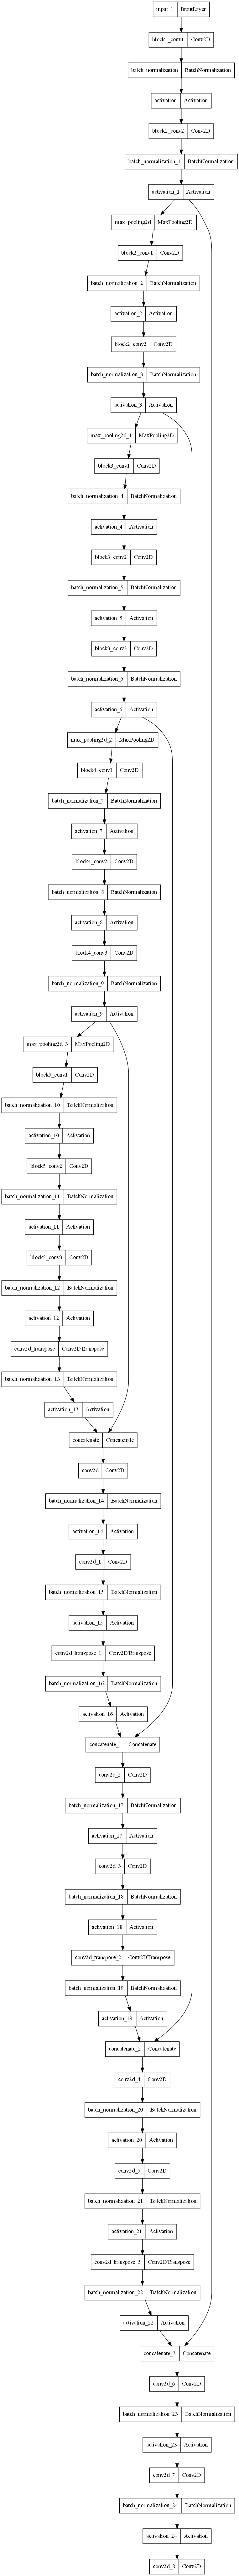

In [27]:
modelC = Unet(2, (112, 160, 3))

plot_model(modelC, to_file='modelC.png')

Обучаем модель

In [41]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=20, validation_data=(xTrain, yTrain))

Epoch 1/10
140/140 [==============================] - 45s 325ms/step - loss: 0.0027 - dice_coef: 0.9983 - val_loss: 0.0026 - val_dice_coef: 0.9984
Epoch 2/10
140/140 [==============================] - 45s 319ms/step - loss: 0.0026 - dice_coef: 0.9984 - val_loss: 0.0025 - val_dice_coef: 0.9985
Epoch 3/10
140/140 [==============================] - 45s 319ms/step - loss: 0.0023 - dice_coef: 0.9985 - val_loss: 0.0026 - val_dice_coef: 0.9984
Epoch 4/10
140/140 [==============================] - 45s 320ms/step - loss: 0.0022 - dice_coef: 0.9986 - val_loss: 0.0021 - val_dice_coef: 0.9987
Epoch 5/10
140/140 [==============================] - 45s 320ms/step - loss: 0.0021 - dice_coef: 0.9987 - val_loss: 0.0023 - val_dice_coef: 0.9986
Epoch 6/10
140/140 [==============================] - 45s 321ms/step - loss: 0.0022 - dice_coef: 0.9986 - val_loss: 0.0025 - val_dice_coef: 0.9985
Epoch 7/10
140/140 [==============================] - 45s 321ms/step - loss: 0.0021 - dice_coef: 0.9987 - val_loss: 0.

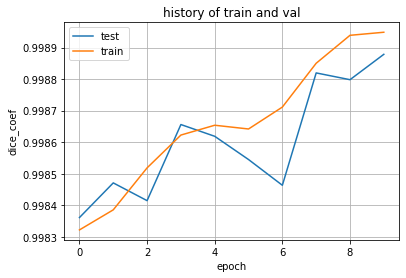

In [42]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.title('history of train and val')
plt.show()

Тест модели

In [43]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/10
140/140 [==============================] - 37s 267ms/step - loss: 0.0017 - dice_coef: 0.9990 - val_loss: 0.0195 - val_dice_coef: 0.9955
Epoch 2/10
140/140 [==============================] - 37s 264ms/step - loss: 0.0015 - dice_coef: 0.9990 - val_loss: 0.0198 - val_dice_coef: 0.9956
Epoch 3/10
140/140 [==============================] - 37s 264ms/step - loss: 0.0014 - dice_coef: 0.9991 - val_loss: 0.0211 - val_dice_coef: 0.9954
Epoch 4/10
140/140 [==============================] - 37s 264ms/step - loss: 0.0014 - dice_coef: 0.9991 - val_loss: 0.0207 - val_dice_coef: 0.9955
Epoch 5/10
140/140 [==============================] - 37s 264ms/step - loss: 0.0014 - dice_coef: 0.9992 - val_loss: 0.0211 - val_dice_coef: 0.9956
Epoch 6/10
140/140 [==============================] - 37s 264ms/step - loss: 0.0013 - dice_coef: 0.9992 - val_loss: 0.0217 - val_dice_coef: 0.9955
Epoch 7/10
140/140 [==============================] - 37s 264ms/step - loss: 0.0012 - dice_coef: 0.9992 - val_loss: 0.

In [44]:
pred = modelC.predict(xTest)
print(pred.shape)

22/22 [==============================] - 2s 105ms/step
(700, 112, 160, 2)


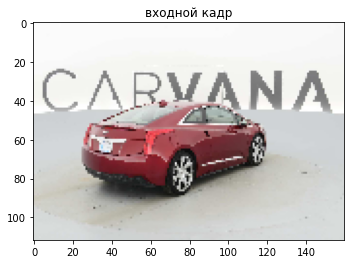

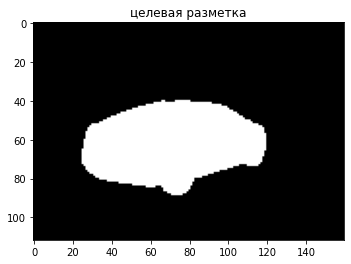

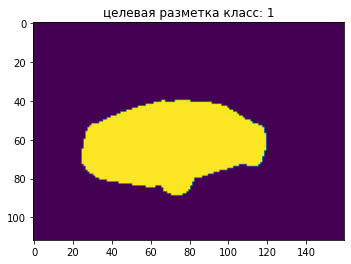

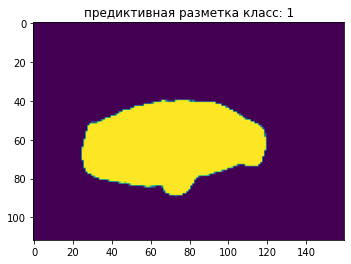

In [47]:
n = 170
class_ =1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()